[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b-koopman/VLM_inference/blob/main/VLM_inference_pt2_performance.ipynb)


# VLM (Vision-Language Models) Inference (Part 2: Performance Metrics)

This part will focus on inputs and outputs from LLMs (especially VLMs) and how they relate to performance.  We'll roughly touch on metrics like TTFT/TPOT and how these relate to inference engines like vLLM or TRT-LLM, though we won't cover those in depth for this part.

## Architecture Review (From Part 1)

Recall from [Part1: Architecture](https://github.com/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb) that the architecture for VLMs includes both the "LLM" component, and the "Image Encoding component".  This even holds true for "native multimodal" models like LLaMA 4, the image still needs to be passed through a ViT to be transformed into embeddings.

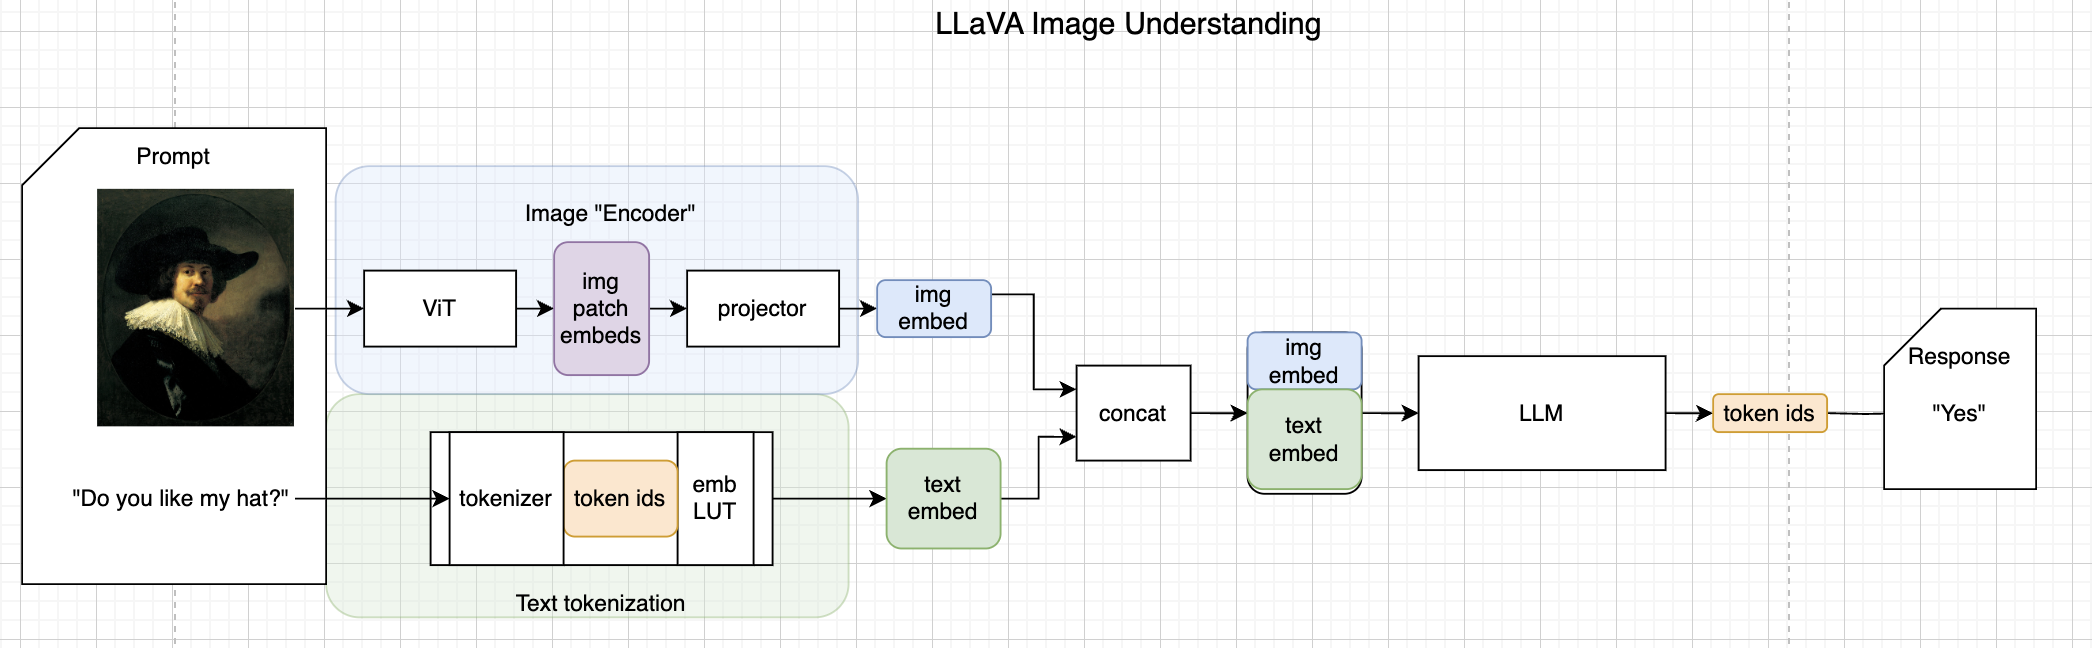

### LLM Latency/performance components

First, let's talk about terminology to define the vocabulary we will use during measurement.

- TTFT (Time To First Token) - `input tok/s`
  - How long it takes from calling the model for the first token to be produced in the output.
  - Encompasses "Encoding Latency"
  - *Performance Impact*: This usually dominates latency/throughput for shorter responses, like multiple choice VQA tasks or classification.
- TPOT (Time Per Output Token) - `output tok/s`
  - How long it takes for a single token to be generated.  This means that the longer an output sequence is (e.g. the more tokens generated per prompt) the longer it takes. example -> you write a 1000 word document, this might roughly be 2500 tokens, at a resonable 100 output tok/s, this is `2500 / 100 = 25 seconds`. If you double that, it will take `30 seconds` for the entire query to complete.
  - *Performance Impact*: For longer generations, latency, and overall prompt throughput will be governed by TPOT
- Prompt / input token length
  - The input to the model, in the case of VLMs
  - *Performance Impact*: In a multimodal VLM context, this influences the latency of image encoding, which is proportional to the number of images to be encoded.
- Context window length
  - The maximum number of input tokens an LLM can handle.
  - This is limited by 1) training context and 2) any inference techniques that can be used to extend the context length like rotary embeddings. **TODO b-koopman: link GLM4.5-V or Qwen2.5VL Tech Report discussing native trained context vs. extended**


#### Review for Tokens
For a review of what "Tokens" are and how they relate to input/output, and how images are represented as tokens, see [Part1](https://github.com/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb)

#### Performance Engineering Reference

As supplemental material, be sure to also check out the [Databricks performance engineering best practices document](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices), which addresses some of the above metrics, and more in-depth discussion of measurement.

### Composition of Latency

While the [Databricks guide](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices) defines latency as


$$
Latency = TTFT + TPOT * tok_{out}
$$

Where $tok_{out}$ is total output tokens.



However, in a VLM setting, it is helpful to think of this more as a composition of encoding latencies, as well as LLM latency.

$$
Latency = Encode_{image}( img_{in} ) + Tokenization_{text} + Encode_{LLM} + TPOT * tok_{out}
$$

where $Encode_{image}( img_{in} )$ is a function describing the encoding latency of $img_{in}$ separate images.

Text tokenization is negligible in this scenario (as we'll see below) so this can be more simply expressed as

$$
Latency = Encode_{images} + Encode_{LLM} + TPOT * tok_{out}
$$

### Measuring latency for real life

Let's focus on a smaller llava implemenation, so we can fit it on a cheaper, more accessible GPU for the demo/exploration.

Specifically: [llava-hf/llava-onevision-qwen2-0.5b-ov-hf](https://huggingface.co/llava-hf/llava-onevision-qwen2-0.5b-ov-hf)


Later, we'll discuss how this transfers to larger models.

In [1]:
!pip install bitsandbytes
!pip install torch torchvision torchaudio
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 33.6 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.0
    Uninstalling sentence-transformers-5.1.0:
      Successfully uninstalled sentence-transformers-5.1.0


In [ ]:
import requests
from PIL import Image
import time

import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

model_id = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True,
).to(0)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What are these?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)


In [ ]:
image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(images=[raw_image], text=prompt, return_tensors='pt').to(0, torch.float16)

In [ ]:
import gradio as gr
import time
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

# Assuming model and processor are already loaded in previous cells

def stream_inference(image, text):
    if image is None:
        yield "Please upload an image."
        return

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text},
                {"type": "image"},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(images=[image], text=prompt, return_tensors='pt').to(0, torch.float16)

    input_ids_len = inputs.input_ids.shape[-1]
    full_output = ""
    start_time = time.time()
    ttft = None

    # Use the generate method with streaming
    for output in model.generate(**inputs, max_new_tokens=512, do_sample=False, stream=True):
        decoded_token = processor.decode(output[0][input_ids_len:], skip_special_tokens=True)
        if ttft is None:
            ttft = time.time() - start_time
            print(f"TTFT: {ttft:.4f} seconds")
        full_output += decoded_token
        yield full_output

    end_time = time.time()
    total_latency = end_time - start_time
    total_tokens = len(processor.encode(full_output, add_special_tokens=False))
    if total_tokens > 0:
        tpot = (total_latency - (ttft if ttft is not None else 0)) / total_tokens
        print(f"Total Latency: {total_latency:.4f} seconds")
        print(f"Total Output Tokens: {total_tokens}")
        print(f"TPOT: {tpot:.4f} seconds per token")

# Create the Gradio interface
iface = gr.Interface(
    fn=stream_inference,
    inputs=[gr.Image(type="pil"), gr.Textbox(label="Prompt")],
    outputs=gr.Textbox(label="Generated Text"),
    title="VLM Streaming Inference Demo",
    live=True,
)

iface.launch()

### Compute TTFT with an image
First, we'll call the model with: 1 image, relatively short text input, and `max_new_tokens=1`, this way we know that we will only produce the first token, and by definition our latency

NOTE: max output tokens can be configured during the call to the model via the `model.generate(` call, generallly this can be configured at call-time, such also when calling the Fireworks Inference API **TODO b-koopman add link to Fireworks API**

In [ ]:
input_ids_len = inputs.input_ids.shape[-1]
print(f"Prompt with image is {input_ids_len} tokens long.")

Prompt with image is 2941 tokens long.


In [ ]:
output = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)
print(processor.decode(output[0][input_ids_len:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


cat


In [ ]:
# output token length is input_len + output_len, see that we have created a single token, e.g. "cat"
print(f"Output Token Length: {output[0].shape[-1] - input_ids_len}")

Output Token Length: 1


In [ ]:
# Warmup
_ = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
multimodal_ttft = 0
for _ in range(10):
  start_time = time.time()
  _ = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)
  multimodal_ttft += time.time() - start_time
multimodal_ttft /= 10
print(f"TTFT With Image: {multimodal_ttft} seconds")

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


TTFT With Image: 5.092006134986877 seconds


### Compute Image Encoding "Tokenization" Latency

Same prompt as before, but without the image. In order to do this, we want to pass the same number of input tokens to the LLM, but from text, not images, this let's us isolate the image encoding latency specifically.


NOTE the output will be a bit garbage, since it isn't conditioned on an actual image, but from a latency perspective it is identical to a semantically relevant answer.

In [ ]:

def generate_prompt(input_ids_len:int):
  # Generate arbitrary text with a length of input_ids_len tokens
  # We can repeat a simple sentence until the token length is approximately input_ids_len
  arbitrary_text = "Write me a poem like a pirate "
  generated_text = "Initial text. " # Initialize with a small piece of text
  while processor(text=generated_text, return_tensors='pt').input_ids.shape[-1] < input_ids_len:
      generated_text += arbitrary_text

  # Trim the text if it exceeds the desired token length
  input_ids = processor(text=generated_text, return_tensors='pt').input_ids
  if input_ids.shape[-1] > input_ids_len:
      # Decode and re-encode to get closer to the exact token length
      generated_text = processor.decode(input_ids[0][:input_ids_len], skip_special_tokens=True)

  input_ids = processor(text=generated_text, return_tensors='pt').input_ids
  print(f"Generated text with {input_ids_len} tokens:")
  print(generated_text)
  assert(input_ids.shape[-1] == input_ids_len)
  return generated_text

In [ ]:

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": generate_prompt(input_ids_len)},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=None, text=prompt, return_tensors='pt').to(0, torch.float16)

In [ ]:
input_ids_len = inputs.input_ids.shape[-1]
print(f"Prompt with only text is {input_ids_len} tokens long.")

Prompt with only text is 2948 tokens long.


In [ ]:
output = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)
print(processor.decode(output[0][input_ids_len:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


text


In [ ]:
# warmup
_ = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
textonly_ttft = 0
for _ in range(10):
  start_time = time.time()
  _ = model.generate(**inputs, max_length=input_ids_len+1, do_sample=False)
  textonly_ttft += time.time() - start_time
textonly_ttft /= 10
print(f"TTFT With Text Only: {textonly_ttft} seconds")

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


TTFT With Text Only: 5.037140727043152 seconds


In [ ]:
print(f"Image Encoding Latency for a single image is {multimodal_ttft - textonly_ttft} seconds")

Image Encoding Latency for a single image is 0.05486540794372541 seconds


### Time Per Output Token

Let's meaningfully increase output length.  We can use this to calculate TPOT (e.g. $TPOT = (Latency - TTFT) / tok$, so we can derive this with our prior TTFT calculation.

In [ ]:
textonly_latency = 0
for _ in range(10):
  start_time = time.time()
  output = model.generate(**inputs, max_length=input_ids_len+512, do_sample=False)
  textonly_latency += time.time() - start_time
textonly_latency /= 10
output_tokens = output[0].shape[-1] - input_ids_len
print(f"Avg. Text Only Latency: {textonly_latency} seconds")

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Avg. Text Only Latency (-2709 output length): 0.0 seconds


In [ ]:
# Calculate TPOT
tpot = (textonly_latency - textonly_ttft) / output_tokens
print(f"TPOT: {tpot} seconds per token")

TPOT: 0.06092779396116271 seconds per token


#### Observe how TPOT meaningfully increases with input token length

In [ ]:

def generate_inputs(input_ids_len:int):
  conversation = [
      {

        "role": "user",
        "content": [
            {"type": "text", "text": generate_prompt(input_ids_len)},
          ],
      },
  ]
  prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
  inputs = processor(images=None, text=prompt, return_tensors='pt').to(0, torch.float16)
  return inputs

In [ ]:
PROFILE_ITERATIONS = 10

In [ ]:
request_latency = {}
for input_ids_len in [32, 64, 128, 512, 1024]:
  output_ids_len = 128
  inputs = generate_inputs(input_ids_len)
  duration_sec = 0
  for _ in range(PROFILE_ITERATIONS):
    start_time = time.time()
    _ = model.generate(**inputs, min_length=input_ids_len + output_ids_len, max_length=input_ids_len + output_ids_len, do_sample=False)
    duration_sec += time.time() - start_time
  duration_sec /= PROFILE_ITERATIONS
  request_latency[input_ids_len] = duration_sec

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Generated text with 32 tokens:
Initial text. Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Generated text with 64 tokens:
Initial text. Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Generated text with 128 tokens:
Initial text. Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Generated text with 512 tokens:
Initial text. Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a p

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Generated text with 1024 tokens:
Initial text. Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a pirate Wrote me a poem like a 

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


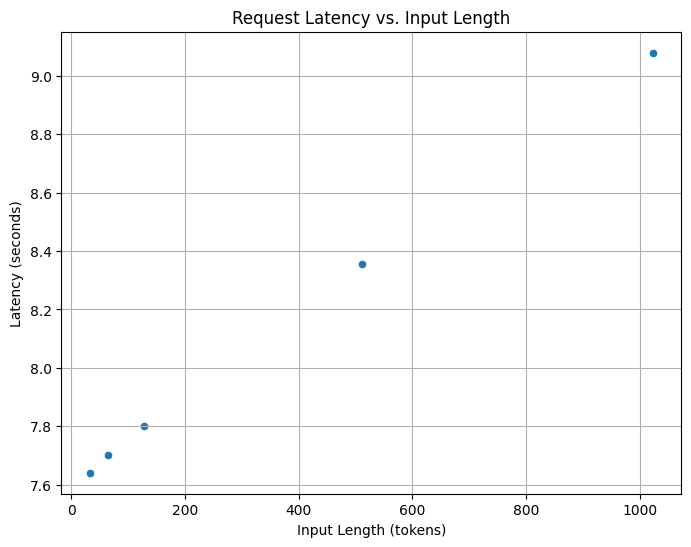

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the request_latency dictionary to a pandas DataFrame for easier plotting
request_latency_df = pd.DataFrame(list(request_latency.items()), columns=['Input Length', 'Latency (sec)'])

# Create a scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=request_latency_df, x='Input Length', y='Latency (sec)')
plt.title('Request Latency vs. Input Length')
plt.xlabel('Input Length (tokens)')
plt.ylabel('Latency (seconds)')
plt.grid(True)
plt.show()

### Request Batching

We already talked a bit in [Part 1](https://colab.research.google.com/github/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb) about image batching (e.g. inference on multiple images in the same call). This also can apply to prompts or inputs.


Let's see how this scales.  For batching, we'll look at tok/sec and prompt/seq in addition to overall request latency.  This is important, since there is a classic latency/throughput tradeoff with LLM inference.


Note: In this case we are using "tok/sec" which is a blended representation of both input tokens, and output tokens, which allows us to give a joined representation of overall prompt latency.

In [ ]:
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")

def batch_inputs(batch_size:int = 1):
  conversations = [[
      {

        "role": "user",
        "content": [
            {"type": "text", "text": "You are a pirate, write me a poem!",},
            {"type": "image"},
          ],
      },
  ],] * batch_size
  # Create separate copies of the image for each item in the batch
  images = [raw_image.copy() for _ in range(batch_size)]
  prompts = [ processor.apply_chat_template(conv, add_generation_prompt=True)
            for conv in conversations ]
  inputs = processor(images=images, text=prompts, return_tensors='pt').to(0, torch.float16)
  return inputs

In [ ]:
import time
PROFILE_ITERATIONS = 5


In [ ]:
batch_metrics = {}
for batch_size in [1, 2, 4, 8, 16]:
  inputs = batch_inputs(batch_size)
  input_ids_len = inputs.input_ids.shape[-1]
  output_ids_len = 512
  print(f"Batch inference for batch of {batch_size}")
  # warmup
  outputs = model.generate(**inputs, min_length=input_ids_len + output_ids_len, max_length=input_ids_len + output_ids_len, do_sample=False)

  duration_sec = 0
  for _ in range(PROFILE_ITERATIONS):
    start_time = time.time()
    outputs = model.generate(**inputs, min_length=input_ids_len + output_ids_len, max_length=input_ids_len + output_ids_len, do_sample=False)
    duration_sec += time.time() - start_time

  duration_sec /= PROFILE_ITERATIONS
  tok_per_sec = batch_size * (input_ids_len + output_ids_len) / duration_sec
  prompt_per_sec = batch_size / duration_sec
  batch_metrics[(batch_size, output_ids_len)] = {"tok_per_sec": tok_per_sec, "prompt_per_sec": prompt_per_sec}

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Batch inference for batch of 1


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Batch inference for batch of 2


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Batch inference for batch of 4


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Batch inference for batch of 8


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Batch inference for batch of 16


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
batch_metrics

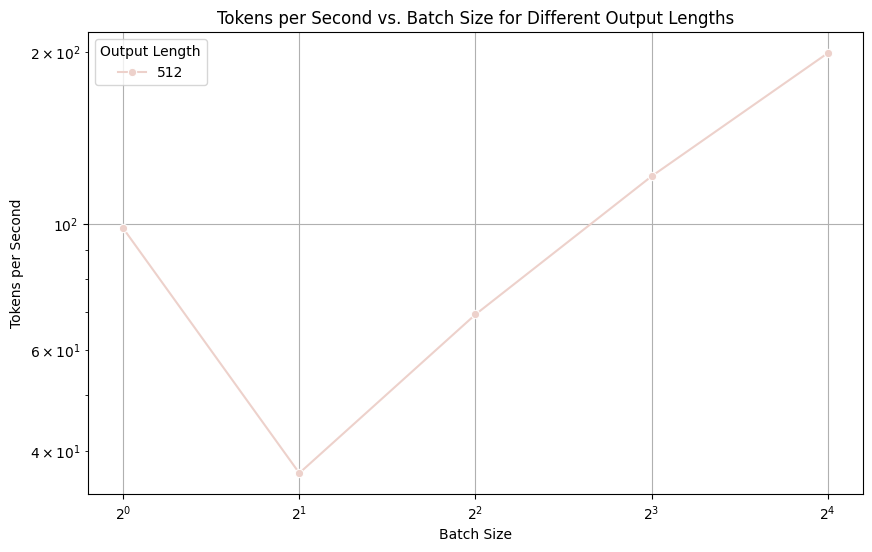

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the batch_metrics dictionary to a list of dictionaries for easier DataFrame creation
data = []
for (batch_size, output_ids_len), metrics in batch_metrics.items():
    data.append({
        "batch_size": batch_size,
        "output_ids_len": output_ids_len,
        "tok_per_sec": metrics["tok_per_sec"],
        "prompt_per_sec": metrics["prompt_per_sec"]
    })

# Create a pandas DataFrame
batch_metrics_df = pd.DataFrame(data)

# Create the seaborn plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=batch_metrics_df, x='batch_size', y='tok_per_sec', hue='output_ids_len', marker='o')

plt.title('Tokens per Second vs. Batch Size for Different Output Lengths')
plt.xlabel('Batch Size')
plt.ylabel('Tokens per Second')
plt.grid(True)
plt.xscale('log', base=2) # Use log scale for batch size
plt.yscale('log') # Use log scale for throughput
plt.legend(title='Output Length')
plt.show()

### Beyond batching with `transformers`

We've seen above about how performance can be effectively scaled (to a point) by different batching strategies.  One downside of how `transformers` handles this is that all prompts must be assembed into a batch at call-time.  Other libraries that are optimized for serving at scale, like [vLLM (continuous batching)](https://docs.vllm.ai/en/latest/), [SGLang(continuous batching)](https://docs.sglang.ai/) or [TRT-LLM (IFB/continuous batching)](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-now-accelerates-encoder-decoder-models-with-in-flight-batching/) offer different batching strategies that are more flexible, and can still perform batch inference even if prompts do not arrive synchronously.


We'll talk more about this more optimized infrastructure in Parts 3+4!

## Thanks for Reading!

Any questions / comments / improvements can be left via github issues, or contacting via github user [`b-koopman`](https://github.com/b-koopman).